In [68]:
import CoolProp.CoolProp as CP
import matplotlib.pyplot as plt
import numpy as np

def plot_sat(Fluid, chart, ax=None, subplot=False, numpoints=200):
    if ax == None:
        fig, ax = plt.subplots(1, 1, figsize=(8,6))
    prop1, prop2 = chart[0], chart[1]
    # propriedade crítica
    p_crit = CP.PropsSI('pcrit', Fluid)
    T_crit = CP.PropsSI('Tcrit', Fluid)
    rho_crit = CP.PropsSI('rhocrit', Fluid)
    h_crit = CP.PropsSI('H', 'P', p_crit, 'T', T_crit, Fluid)
    s_crit = CP.PropsSI('S', 'P', p_crit, 'T', T_crit, Fluid)
    
    # valor mínimo
    p_min = CP.PropsSI('ptriple', Fluid) + 100
    T_min = CP.PropsSI('Ttriple', Fluid) + 0.1
    rho_min = CP.PropsSI('D', 'P', p_min, 'T', T_min, Fluid)
    h_min = CP.PropsSI('H', 'P', p_min, 'T', T_min, Fluid)
    s_min = CP.PropsSI('S', 'P', p_min, 'T', T_min, Fluid)
    
    # Dicionário de propriedades
    prop_dict = {'p': ['Pressão (kPa)', 'P', p_crit, p_min],
                 'T': ['Temperatura (K)', 'T', T_crit, T_min],
                 'v': ['Volume específico (m3/kg)', 'D', rho_crit, rho_min],
                 'h': ['Entalpia (kJ/kg)', 'H', h_crit, h_min],
                 's': ['Entropia (kJ/kg.K)', 'S', s_crit, s_min]}
    
    # cálculo
    entry = prop_dict[prop1]
    out = prop_dict[prop2]
    prop1_array = np.linspace(entry[3], entry[2], numpoints)
    prop2_array = np.zeros(2 * numpoints - 1)
    for i, var in enumerate(prop1_array[:-1]):
        prop2_array[i] = CP.PropsSI(out[1], 'Q', 0, entry[1], var, Fluid)
        prop2_array[::-1][i] = CP.PropsSI(out[1], 'Q', 1, entry[1], var, Fluid)
    prop2_array[numpoints - 1] = out[2]
    prop1_array = np.append(prop1_array, prop1_array[::-1][1:])
       
    # Plotando o gráfico
    
    if chart == 'pv':
        ax.loglog(1 / prop2_array, prop1_array / 1000)
        ax.set_xlim(min(1 / prop2_array) / 10, max(1 / prop2_array) * 10)
    elif chart == 'Ts':
        ax.plot(prop2_array / 1000, prop1_array)
    elif chart == 'ph' or chart == 'pT':
        if prop2 == 'h':
            prop2_array = prop2_array / 1000
        ax.semilogy(prop2_array, prop1_array / 1000)
    elif chart == 'Tv':
        ax.semilogx(1 / prop2_array, prop1_array)
        ax.set_xlim(min(1 / prop2_array) / 10, max(1 / prop2_array) * 10)
    ax.set_title(chart + '-diagram')
    ax.set_xlabel(out[0])
    ax.set_ylabel(entry[0])
    if not subplot:
        plt.show()
        
def rankine(Fluid, T, p_low, p_high, eta_pump=1.0, eta_turb=1.0):   
    T_1 = T
    T_3 = CP.PropsSI('T', 'P', p_high, 'Q', 1, Fluid)
    s_1 = CP.PropsSI('S', 'P', p_low, 'T', T_1, Fluid)
    s_2 = s_1 / eta_pump
    T_2 = CP.PropsSI('T', 'P', p_high, 'S', s_2, Fluid)
    s_3 = CP.PropsSI('S', 'Q', 1, 'T', T_3, Fluid)
    s_range = np.linspace(s_2, s_3, 50)    
    T_range = [CP.PropsSI('T', 'P', p_high, 'S', s, Fluid) for s in s_range]    
    s_4 =  s_3 / eta_turb
    T_4 = T_1
    plt.plot([s_1 / 1000, s_2 / 1000], [T, T_2], 'k')
    plt.plot(s_range / 1000, T_range, 'k')
    plt.plot([s_3 / 1000, s_4 / 1000], [T_3, T_4], 'k')
    plt.plot([s_4 / 1000, s_1 / 1000], [T_4, T_1], 'k')
    

In [72]:
import matplotlib.pyplot as plt
%matplotlib inline
from ipywidgets import interact, IntSlider, FloatSlider
import numpy as np
import CoolProp.CoolProp as CP

Fluid = 'Acetone'
M = CP.PropsSI('M', Fluid) * 1000
v = np.logspace(-3, 2, 500) * M
a = 16.02
b = 0.1124

fig = plt.figure()
def f(T):
    plot_sat(Fluid, 'pv',subplot=True)
    plt.plot(1 / CP.PropsSI('rhocrit', Fluid), CP.PropsSI('Pcrit', Fluid) / 1000, 'ok')
    plt.loglog(v / M, (8.314 * T / (v - b) - (a * 100)/(v)**2), label='EOS - van der Waals')
    fig.canvas.draw()
    plt.legend()
    plt.show()
interact(f, T=IntSlider(430, 430, 530, 10, description='Temperature (K)'));

In [73]:
Fluid = 'Water'
M = CP.PropsSI('M', Fluid) * 1000
v = np.logspace(-3, 2, 500) * M
a = 5.536
b = 0.03049

fig = plt.figure()
def f(eta):
    plot_sat(Fluid, 'Ts',subplot=True)
    rankine('Water', 300, 100000, 2000000, 0.75, eta)
    fig.canvas.draw()
    #plt.legend()
    plt.show()
interact(f, eta=FloatSlider(value=0.7, min=0.1, max=1.0, step=0.1));

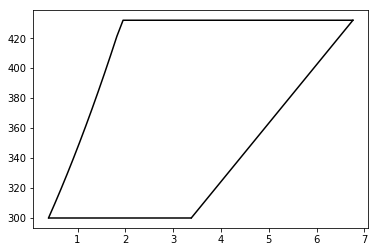

In [51]:
def rankine(Fluid, T, p_low, p_high, eta_pump=1.0, eta_turb=1.0):   
    T_1 = T
    T_3 = CP.PropsSI('T', 'P', p_high, 'Q', 1, Fluid)
    s_1 = CP.PropsSI('S', 'P', p_low, 'T', T_1, Fluid)
    s_2 = s_1 / eta_pump
    T_2 = CP.PropsSI('T', 'P', p_high, 'S', s_2, Fluid)
    s_3 = CP.PropsSI('S', 'Q', 1, 'T', T_3, Fluid)
    s_range = np.linspace(s_2, s_3, 50)    
    T_range = [CP.PropsSI('T', 'P', p_high, 'S', s, Fluid) for s in s_range]    
    s_4 = eta_turb * s_3
    T_4 = T_1
    plt.plot([s_1 / 1000, s_2 / 1000], [T, T_2], 'k')
    plt.plot(s_range / 1000, T_range, 'k')
    plt.plot([s_3 / 1000, s_4 / 1000], [T_3, T_4], 'k')
    plt.plot([s_4 / 1000, s_1 / 1000], [T_4, T_1], 'k')
rankine('Water', 300, 100000, 600000, eta_turb=0.5)
    